**Nama: Muhammad Abel Al Rasyid**

**NIM: 2702406644**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
import cv2
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
df = pd.read_csv('AP003.csv')
df.head()

,From Date,To Date,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),...,Temp (degree C),RH (%),WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),VWS (m/s),AT (degree C),RF (mm),Xylene (ug/m3)
0,2017-07-01 00:00:00,2017-07-01 01:00:00,50.00,91.75,3.33,27.70,17.48,NaN,24.35,1.33,...,55.22,83.25,1.67,285.50,6.75,737.0,0.03,26.30,0.00,0.65
1,2017-07-01 01:00:00,2017-07-01 02:00:00,30.75,59.25,1.20,20.78,11.40,0.03,8.23,1.77,...,57.48,84.50,2.50,299.50,6.75,736.0,0.05,25.00,1.50,0.50
2,2017-07-01 02:00:00,2017-07-01 03:00:00,NaN,NaN,1.17,4.07,2.73,0.10,10.77,1.20,...,58.67,86.00,0.77,285.67,6.67,736.0,0.03,24.17,0.33,0.43
3,2017-07-01 03:00:00,2017-07-01 04:00:00,8.00,NaN,2.58,6.38,5.30,NaN,19.78,1.58,...,58.93,86.00,1.55,302.50,6.00,735.0,0.08,24.10,0.00,0.63
4,2017-07-01 04:00:00,2017-07-01 05:00:00,33.25,NaN,5.30,21.03,15.47,0.15,22.40,2.25,...,59.88,86.00,2.30,297.25,6.00,735.0,0.08,24.90,0.00,0.67


Mengecek tipe data dan missing value

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50400 entries, 0 to 50399
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   From Date        50400 non-null  object 
 1   To Date          50400 non-null  object 
 2   PM2.5 (ug/m3)    44691 non-null  float64
 3   PM10 (ug/m3)     45018 non-null  float64
 4   NO (ug/m3)       46252 non-null  float64
 5   NO2 (ug/m3)      45705 non-null  float64
 6   NOx (ppb)        47040 non-null  float64
 7   NH3 (ug/m3)      45756 non-null  float64
 8   SO2 (ug/m3)      43604 non-null  float64
 9   CO (mg/m3)       46993 non-null  float64
 10  Ozone (ug/m3)    45309 non-null  float64
 11  Benzene (ug/m3)  46678 non-null  float64
 12  Toluene (ug/m3)  46678 non-null  float64
 13  Temp (degree C)  46335 non-null  float64
 14  RH (%)           46520 non-null  float64
 15  WS (m/s)         46522 non-null  float64
 16  WD (degree)      44710 non-null  float64
 17  SR (W/mt2)  

Cek jumlah missing value

In [4]:
df.isnull().sum()

,0
From Date,0
To Date,0
PM2.5 (ug/m3),5709
PM10 (ug/m3),5382
NO (ug/m3),4148
NO2 (ug/m3),4695
NOx (ppb),3360
NH3 (ug/m3),4644
SO2 (ug/m3),6796
CO (mg/m3),3407


In [5]:
df = df.drop_duplicates().reset_index(drop=True) # Membuang Data Duplikat

#Memisahkan kolom Kategorikal dan Numerikal
cat_cols = []
num_cols = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        num_cols.append(i)
    else:
        cat_cols.append(i)

print(cat_cols)
print(num_cols)

['From Date', 'To Date']
['PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (degree)', 'SR (W/mt2)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)', 'RF (mm)', 'Xylene (ug/m3)']


**Sort, Drop, Split data**

In [6]:
# Mengubah 'From Date' ke datetime dan menjadikannya index

df['From Date'] = pd.to_datetime(df['From Date'])
df.set_index('From Date', inplace=True)

# Drop kolom 'To Date' karena tidak dipakai untuk time series
# LSTM itu butuh urutan waktu, dan kolom From Date sudah cukup untuk itu
# To Date cuma beda 1 jam, jadi tidak menambah informasi tambahan

df.drop(columns=['To Date'], inplace=True)

# Sorting berdasarkan waktu
df = df.sort_index()

#Split time series 80% train, 10% val, 10% test
n = len(df)
n_train = int(0.8 * n)
n_val = int(0.1 * n)

df_train = df.iloc[:n_train].copy()
df_val   = df.iloc[n_train:n_train + n_val].copy()
df_test  = df.iloc[n_train + n_val:].copy()

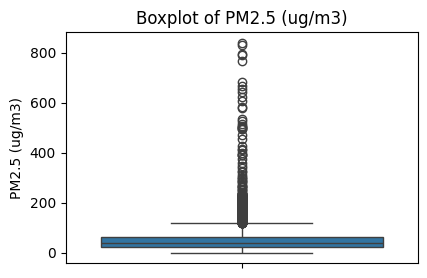

Skewness: 3.8120308404033265
Kurtosis: 48.48340018970142


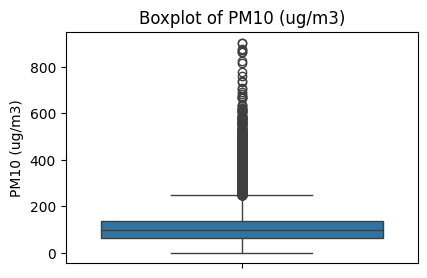

Skewness: 2.1486766161738498
Kurtosis: 8.227009584889002


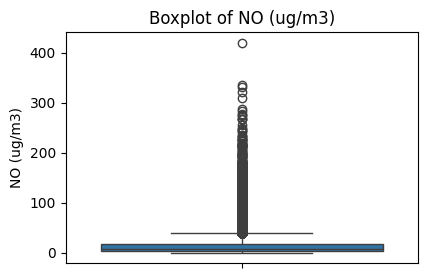

Skewness: 4.012152541960519
Kurtosis: 25.31812501114471


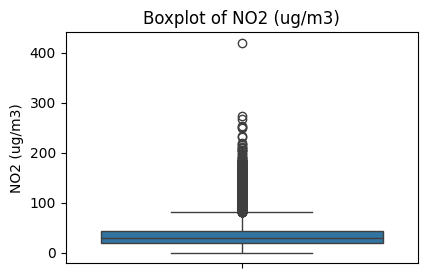

Skewness: 1.927265504801719
Kurtosis: 7.248969095628038


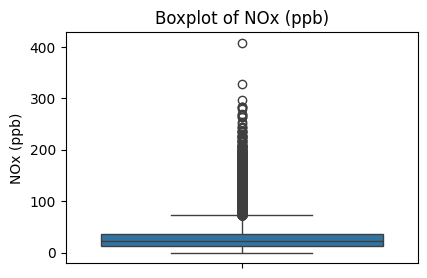

Skewness: 2.5908837540692913
Kurtosis: 10.443009518551188


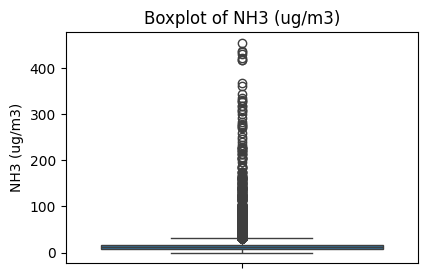

Skewness: 10.591016268361521
Kurtosis: 208.4797057356495


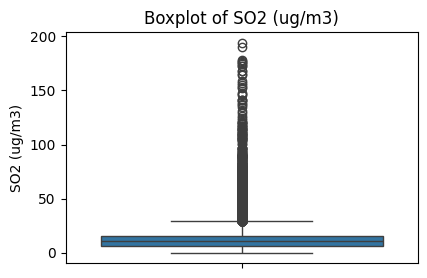

Skewness: 4.648163051137525
Kurtosis: 45.213892212912924


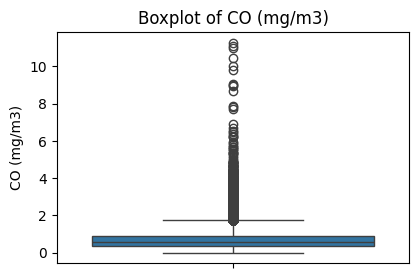

Skewness: 3.086232178353527
Kurtosis: 28.728343935521593


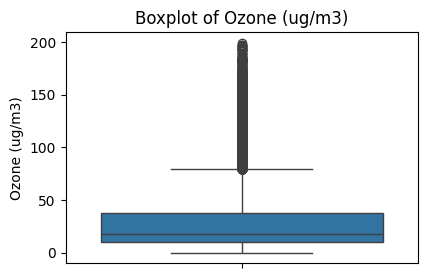

Skewness: 1.8824009979882446
Kurtosis: 3.7433378247036684


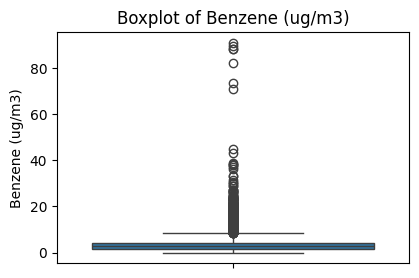

Skewness: 5.031570891167827
Kurtosis: 97.29771288713901


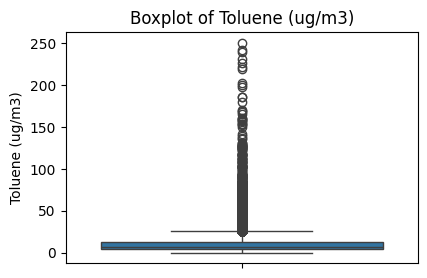

Skewness: 5.3228497794262015
Kurtosis: 59.384152198403164


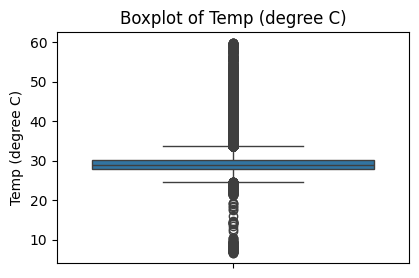

Skewness: 2.8674251310339836
Kurtosis: 22.39783007499976


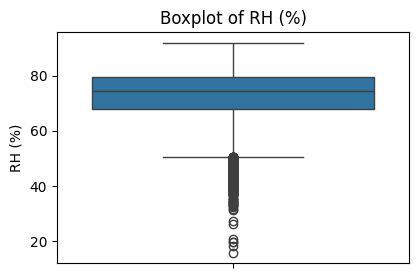

Skewness: -0.7675688099948292
Kurtosis: 0.7524505862734299


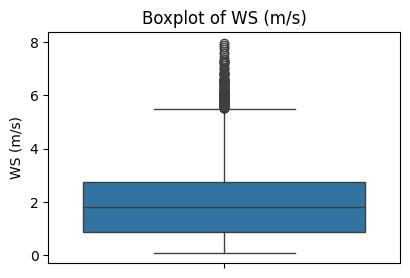

Skewness: 0.5570399750015516
Kurtosis: -0.1368420211952155


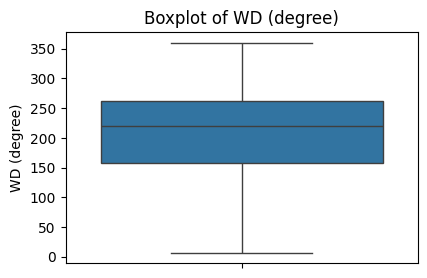

Skewness: -0.34911852741540333
Kurtosis: -0.7480644274386905


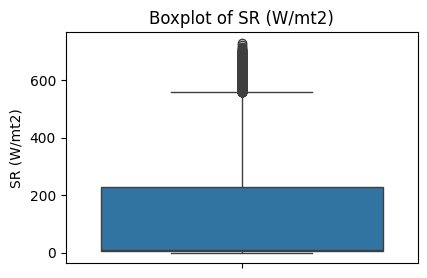

Skewness: 1.2658550457078357
Kurtosis: 0.3000403315050213


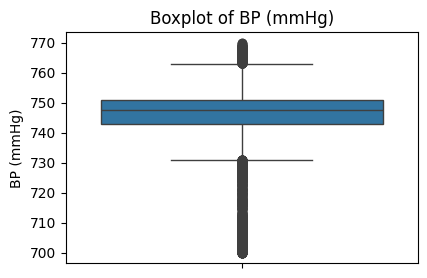

Skewness: -1.2407614524936506
Kurtosis: 6.11967758495874


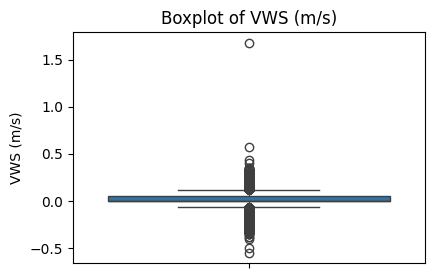

Skewness: 0.36516854095996243
Kurtosis: 8.734654849669555


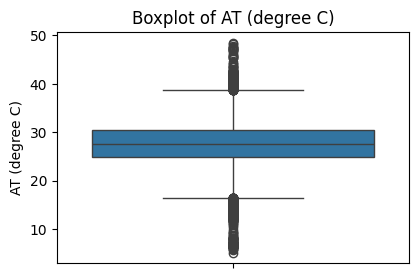

Skewness: -0.14990869659051165
Kurtosis: 0.7565053084001243


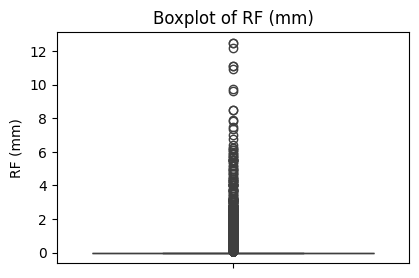

Skewness: 22.378910166308632
Kurtosis: 662.5156496274642


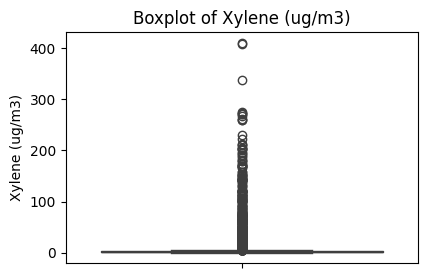

Skewness: 20.243137661715526
Kurtosis: 563.492816302317


In [7]:
def check_distribution_outliers(df, columns): #Mengecek apakah ada outlier atau tidak
    for col in columns:
        plt.figure(figsize=(10, 3))

        # Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

        print('Skewness:', df[col].skew())
        print('Kurtosis:', df[col].kurt())

check_distribution_outliers(df[num_cols], num_cols)

**Imputasi berdasarkan distribusi skewness**

* Antara -0.5 dan +0.5	Hampir normal/simetris impute dengan Mean

* Antara -1 dan -0.5 atau +0.5 dan +1	Sedikit skewed (kiri/kanan)	di impute dengan Mean atau Median

* Antara < -1 atau > +1	Sangat skewed	diimpute dengan median

**Mengecek apakah ada outlier atau tidak**


* Jika Skewness = 0 maka normal

* Jika Skewness lebih besar dari 0.5 makan distribusi miring ke kanan
* Jika Skewness lebih kecil dari 0.5 makan distribusi miring ke kiri


Jika kurtosis itu normalnya ada di angka 3, dan kurtosis ini buat nunjukin puncak yang tajam
Jika kurtosis diatas angka 3 maka puncaknya tajam, jika dibwah 3 maka puncaknya lebih datar

In [8]:
# Memisahkan kolom untuk imputasi median (high skew/outlier)
median_cols = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)',
    'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
    'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'SR (W/mt2)',
    'RF (mm)', 'Xylene (ug/m3)'
]

# Memisahkan kolom untuk imputasi mean (relatif normal)
mean_cols = ['RH (%)', 'WS (m/s)', 'WD (degree)', 'BP (mmHg)', 'VWS (m/s)', 'AT (degree C)']

# Impute median
for col in median_cols:
    median_val = df_train[col].median()
    df_train[col].fillna(median_val, inplace=True)
    df_val[col].fillna(median_val, inplace=True)
    df_test[col].fillna(median_val, inplace=True)

# Impute mean
for col in mean_cols:
    mean_val = df_train[col].mean()
    df_train[col].fillna(mean_val, inplace=True)
    df_val[col].fillna(mean_val, inplace=True)
    df_test[col].fillna(mean_val, inplace=True)

Cek Miss value data setelah di split dengan benar

In [9]:
print("Train NaN:\n", df_train.isnull().sum().sum())
print("Val NaN:\n", df_val.isnull().sum().sum())
print("Test NaN:\n", df_test.isnull().sum().sum())


Train NaN:
 0
Val NaN:
 0
Test NaN:
 0


# 1. a. EDA

**Korelasi Terhadap Target AT (degree C)**

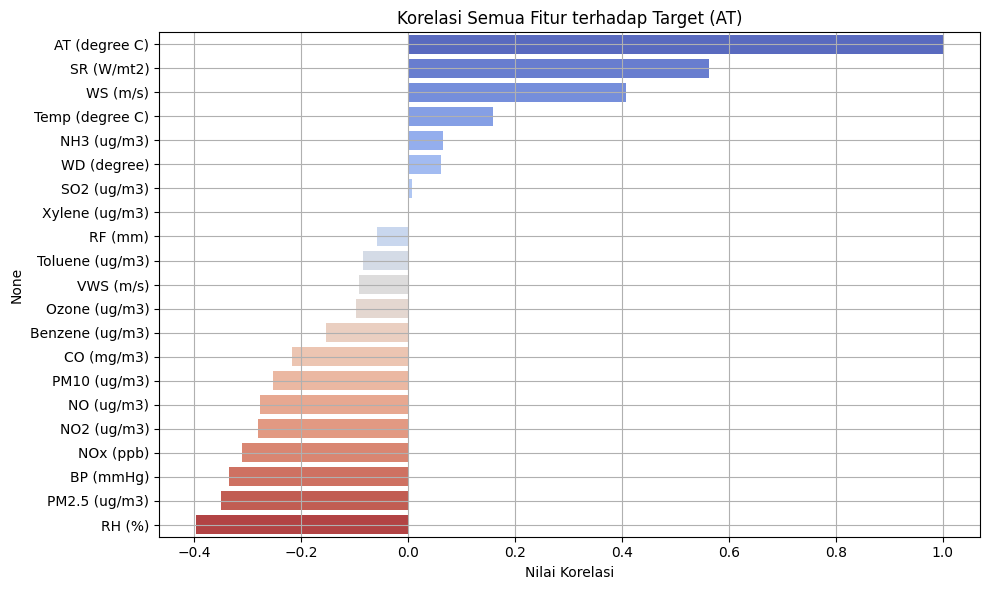

In [10]:
# Korelasi semua kolom terhadap target AT
corr_with_target = df.corr()['AT (degree C)'].sort_values(ascending=False)

# Visualisasi barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
plt.title("Korelasi Semua Fitur terhadap Target (AT)")
plt.xlabel("Nilai Korelasi")
plt.grid(True)
plt.tight_layout()
plt.show()

Membantu mengetahui fitur mana yang paling relevan dengan suhu udara (AT), seperti Temp, SR, dll.

**Tren AT (degree C) Sepanjang Tahun**


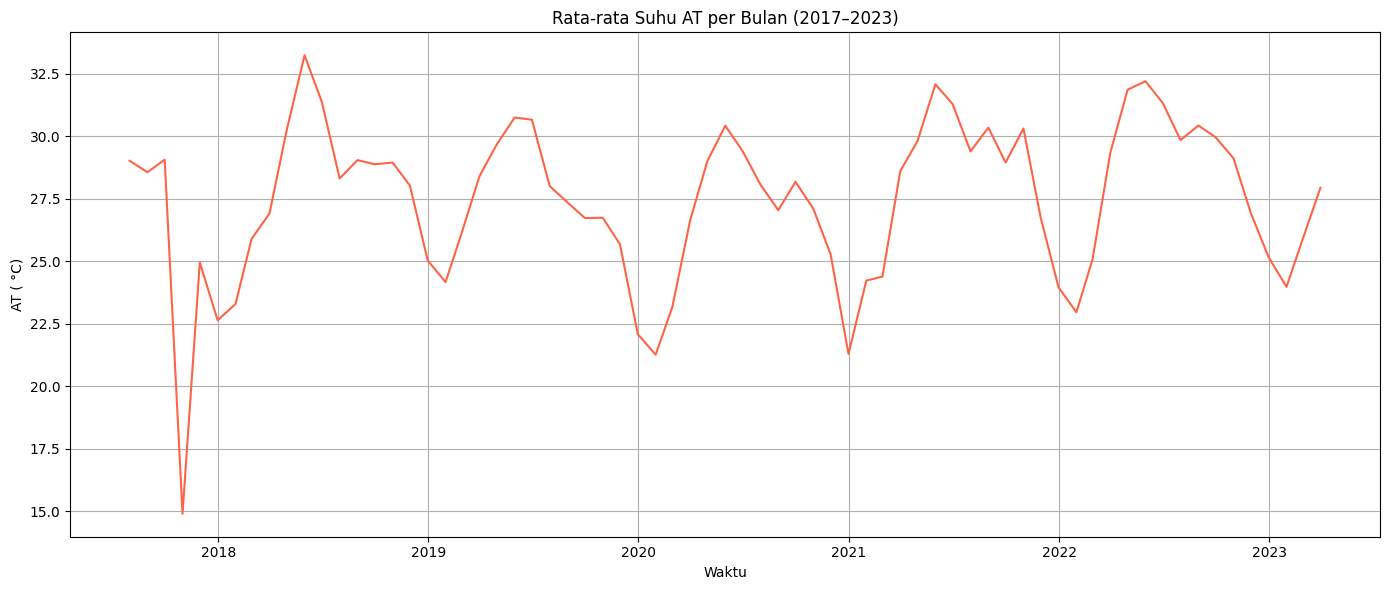

In [11]:
monthly_avg = df['AT (degree C)'].resample('M').mean()

plt.figure(figsize=(14, 6))
plt.plot(monthly_avg.index, monthly_avg.values, color='tomato')

plt.title("Rata-rata Suhu AT per Bulan (2017–2023)")
plt.xlabel("Waktu")
plt.ylabel("AT ( °C)")
plt.grid(True)
plt.tight_layout()
plt.show()


Disini kita bisa melihat tren musiman dan perubahan suhu dari tahun ke tahun informasi ini sangat penting untuk time series

# **Scale**

VWS (m/s) masih boleh pakai StandardScaler karena skewness & kurtosis-nya tidak ekstrem. dan nilainya relatif kecil & tidak terlalu outlier-sensitive.

In [12]:
#Menentukan kolom apa yang akan di scale menggunakan standard sama robust
standard_cols = [
    'RH (%)', 'WS (m/s)', 'WD (degree)', 'VWS (m/s)', 'AT (degree C)'
]

robust_cols = [
    'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'NOx (ppb)',
    'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)', 'Ozone (ug/m3)',
    'Benzene (ug/m3)', 'Toluene (ug/m3)', 'Temp (degree C)', 'SR (W/mt2)',
    'BP (mmHg)', 'RF (mm)', 'Xylene (ug/m3)'
]

In [13]:
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler_std = StandardScaler()
scaler_rob = RobustScaler()

# Menyalin data sebelum transformasi (jaga orisinalitas)
df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

# Scaling menggunakan StandardScale
df_train_scaled[standard_cols] = scaler_std.fit_transform(df_train[standard_cols])
df_val_scaled[standard_cols]   = scaler_std.transform(df_val[standard_cols])
df_test_scaled[standard_cols]  = scaler_std.transform(df_test[standard_cols])

# Scaling menggunakan RobustScale
df_train_scaled[robust_cols] = scaler_rob.fit_transform(df_train[robust_cols])
df_val_scaled[robust_cols]   = scaler_rob.transform(df_val[robust_cols])
df_test_scaled[robust_cols]  = scaler_rob.transform(df_test[robust_cols])

In [14]:
#Mengecek apakah sudah di scale dengan benar di bagian standard nya
df_train_scaled[standard_cols].describe().loc[['mean', 'std']]

,RH (%),WS (m/s),WD (degree),VWS (m/s),AT (degree C)
mean,-6.879858e-16,-1.917338e-16,1.663572e-16,-1.127846e-17,8.233273e-16
std,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00,1.000012e+00


# 1. c. Bikin Sequence untuk LSTM

In [15]:
def create_lstm_sequences(df_scaled, target_col='AT (degree C)', n_steps=5):
    X, y = [], []
    for i in range(n_steps, len(df_scaled)):
        X.append(df_scaled.iloc[i-n_steps:i].values)
        y.append(df_scaled.iloc[i][target_col])
    return np.array(X), np.array(y)

In [16]:
X_train, y_train = create_lstm_sequences(df_train_scaled)
X_val, y_val     = create_lstm_sequences(df_val_scaled)
X_test, y_test   = create_lstm_sequences(df_test_scaled)

In [17]:
print(X_train.shape, y_train.shape)

(40315, 5, 21) (40315,)


Artinya sudah punya 40.315 sampel

Setiap sampel berisi 5 jam data sebelumnya (n_steps = 5)

Setiap jam punya 21 fitur (semua kolom numerikal)

Target (y_train) adalah nilai AT (degree C) 1 jam setelah sequence

In [18]:
#Membuat model LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,291 (5.04 KB)

 Trainable params: 1,291 (5.04 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [19]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.6495 - mae: 0.5629 - val_loss: 0.1245 - val_mae: 0.2443
Epoch 2/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1229 - mae: 0.2087 - val_loss: 0.0843 - val_mae: 0.1866
Epoch 3/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0958 - mae: 0.1656 - val_loss: 0.0716 - val_mae: 0.1707
Epoch 4/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0883 - mae: 0.1529 - val_loss: 0.0667 - val_mae: 0.1640
Epoch 5/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0857 - mae: 0.1484 - val_loss: 0.0668 - val_mae: 0.1626
Epoch 6/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0818 - mae: 0.1445 - val_loss: 0.0664 - val_mae: 0.1694
Epoch 7/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0772 - mae: 0.1424 - val_loss: 0.0645 - val_mae: 0.1587
Epoch 8/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0781 - mae: 0.1396 - val_loss: 0.0638 - val_mae: 0.1590
Epoch 9/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - lo

# 1.d. Modifikasi LSTM

In [20]:
# Modifikasi model: tambah layer, neuron, dropout
model_mod = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])

model_mod.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_mod = model_mod.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


Epoch 1/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.3058 - mae: 0.3721 - val_loss: 0.0819 - val_mae: 0.1923
Epoch 2/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1072 - mae: 0.1930 - val_loss: 0.0713 - val_mae: 0.1803
Epoch 3/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0919 - mae: 0.1705 - val_loss: 0.0658 - val_mae: 0.1639
Epoch 4/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0937 - mae: 0.1665 - val_loss: 0.0681 - val_mae: 0.1674
Epoch 5/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0945 - mae: 0.1632 - val_loss: 0.0632 - val_mae: 0.1620
Epoch 6/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0854 - mae: 0.1556 - val_loss: 0.0612 - val_mae: 0.1545
Epoch 7/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0868 - mae: 0.1546 - val_loss: 0.0635 - val_mae: 0.1634
Epoch 8/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0817 - mae: 0.1503 - val_loss: 0.0611 - val_mae: 0.1532
Epoch 9/20
630/630 ━━━━━━━━━━━━━━━━━━━━ 9s 10

# 1.e. Evaluasi Baseline vs Modifikasi

In [21]:
# Prediksi
y_pred_base = model.predict(X_test).flatten()
y_pred_mod  = model_mod.predict(X_test).flatten()
y_true      = y_test

# Evaluasi function
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    print(f"{name} Evaluation:")
    print(f"  MAE : {mae:.4f}")
    print(f"  MSE : {mse:.4f}")
    print(f"  R^2 : {r2:.4f}")
    print('-' * 30)

# Hasil evaluasi
evaluate_model("Baseline LSTM", y_true, y_pred_base)
evaluate_model("Modified LSTM", y_true, y_pred_mod)


158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Baseline LSTM Evaluation:
  MAE : 0.1552
  MSE : 0.0525
  R^2 : 0.9423
------------------------------
Modified LSTM Evaluation:
  MAE : 0.1514
  MSE : 0.0500
  R^2 : 0.9449
------------------------------


MAE turun dari 0.1552 → 0.1514, artinya rata-rata kesalahan prediksi menurun

MSE turun dari 0.0525 → 0.0500, berarti error kuadratnya lebih kecil (lebih stabil)

R² naik dari 0.9423 → 0.9449, menandakan model mampu menjelaskan variasi data lebih baik

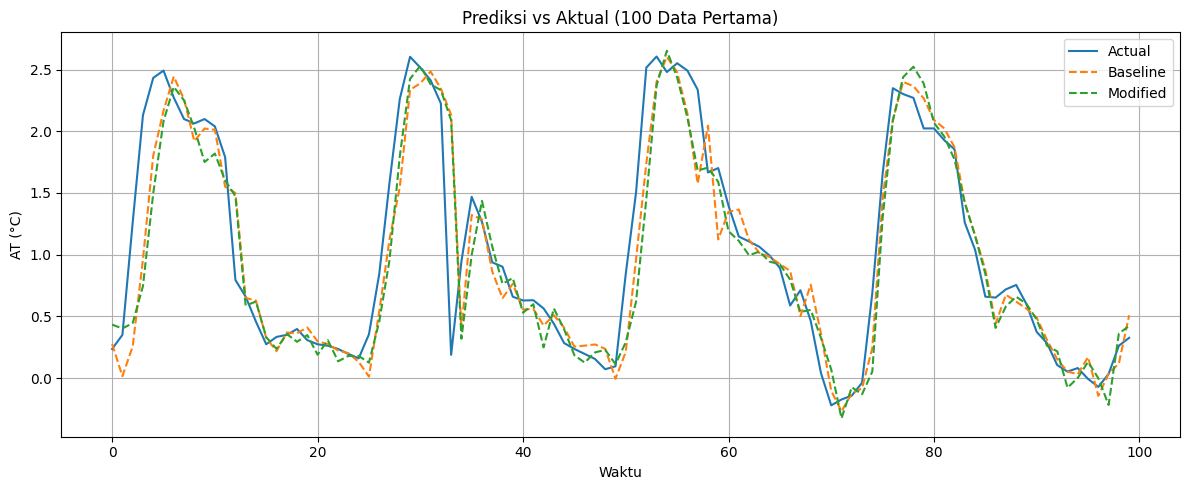

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_true[:100], label='Actual')
plt.plot(y_pred_base[:100], label='Baseline', linestyle='--')
plt.plot(y_pred_mod[:100], label='Modified', linestyle='--')
plt.title('Prediksi vs Aktual (100 Data Pertama)')
plt.xlabel('Waktu')
plt.ylabel('AT (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 1. f. Apakah problem ini mungkin menggunakan time series multivariate, bagaimana mengetahui apakah problem tersebut dapat menjadi multivariate, jelaskan jawaban anda untuk problem ini

Ya, problem ini sangat cocok menggunakan time series multivariate.
Karena:
1. Time series multivariate adalah model yang menggunakan lebih dari satu variabel input yang berubah terhadap waktu untuk memprediksi target di waktu ke depan.

2. Kenapa problem ini cocok?
Target kita adalah AT (degree C), yaitu suhu aktual per jam.

Dataset ini memiliki 21 fitur lain (seperti PM2.5, CO, NO2, RH (%), dll), dan semuanya adalah data time series (berubah tiap jam).

Banyak fitur memiliki korelasi signifikan terhadap AT (misalnya Temp, RH (%), SR, dll).

Dengan menggunakan lebih dari 1 variabel sebagai input, model bisa menangkap hubungan kompleks antar faktor lingkungan dan suhu.

Kesimpulan:
Problem ini merupakan time series multivariate, karena melibatkan banyak fitur time-dependent untuk memprediksi satu target (AT) di waktu mendatang.
Menggunakan model LSTM multivariate memungkinkan model memahami pola kompleks antara polutan, cuaca, dan suhu udara secara akurat.

